In [1]:
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
from pathlib import Path
from torchwi import Tomo2d
from torchwi.io import rsf, CFGParser
from pkrh.torchwi import param_selector, get_land_mask
from SSIM import SSIM
import time

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [3]:
EPOCHS = 500
vmin, vmax = 1.5, 5.0
lr = 0.01

In [4]:
nx=320
ny=50
h=0.1

shape = (nx,ny)
meter_to_km=0.001

In [5]:
nshot = 200
ivel = 39920

sxs = (104 + np.arange(nshot))*h
sy = 0.
ry = 0.

In [6]:
rx = np.zeros((nshot,2),dtype=np.int32)

for ishot in range(nshot):
    rx[ishot,0] = 2 + ishot
    rx[ishot,1] = rx[ishot,0] + 100

print("nshot=%d, sy=%s, ry=%s"%(nshot,sy,ry))

nshot=200, sy=0.0, ry=0.0


In [7]:
rcv_mask = np.zeros((nshot,nx),dtype=bool)

for ishot in range(nshot):
    ir0 = rx[ishot,0]
    ir1 = rx[ishot,1]
    rcv_mask[ishot,ir0:ir1] = True

In [8]:
rcv_mask = torch.from_numpy(rcv_mask)

In [9]:
v = np.load("../../data/ml_vel/vel%05d.npy"%ivel)
v.shape=(nx,ny)

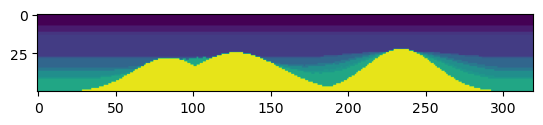

In [10]:
plt.imshow(v.T, vmin=1.5, vmax=5.0)

In [11]:
land_mask = np.zeros((nx,ny),dtype=np.int32)

for ix in range(nx):
    for iy in range(ny):
        if v[ix,iy] == 1.5:
            land_mask[ix,iy] = 0
        else:
            land_mask[ix,iy] = 1

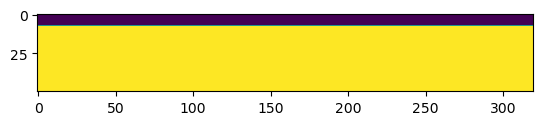

In [12]:
plt.imshow(land_mask.T)

In [13]:
land_mask = torch.from_numpy(land_mask)

In [14]:
#vinit = np.load("./vinit.npy")
vinit = np.load("./vinit_high.npy")
vinit.shape = (nx,ny)

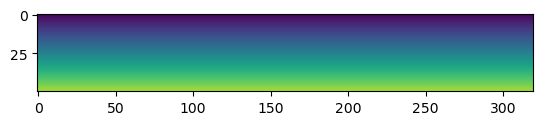

In [15]:
plt.imshow(vinit.T, vmin=1.5, vmax=5.0)

In [16]:
for ix in range(nx):
    for iy in range(ny):
        if land_mask[ix,iy] == 0:
            vinit[ix,iy] = 1.5

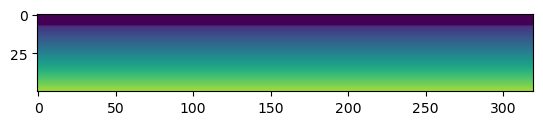

In [17]:
plt.imshow(vinit.T, vmin=1.5, vmax=5.0)

In [18]:
vinit = torch.from_numpy(vinit)

In [19]:
ttime_obs = np.load("../../data/ml_time/time%05d.npy"%ivel)
ttime_obs.shape = (nshot,nx)

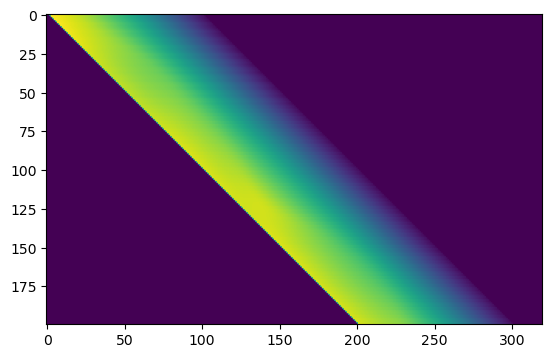

In [20]:
plt.imshow(ttime_obs)

In [21]:
ttime_obs.shape

(200, 320)

In [22]:
ttime_obs = torch.from_numpy(ttime_obs)

In [23]:
vel = param_selector('velocity',vinit,vmin,vmax)
optimizer = torch.optim.SGD(vel.parameters(), lr=lr, nesterov=True, momentum=0.9)

In [24]:
tomo = Tomo2d(nx,ny,h)
freq = 0.05
vmean = 3.0

In [25]:
alpha = 2*np.pi / (20*h) * vmean
omega = 2.*np.pi*freq - alpha * 1.0j

In [26]:
def traveltime_tomo(ttime_obs, vel, num_epoch=None):
    
    losses = []
    norm_losses = []
    since = time.time()
    
    # main loop
    for itr in range(num_epoch+1):

        # frequency loop
        optimizer.zero_grad()

        tomo.factorize(omega, vel())
        ttime = tomo.forward(vel(), torch.from_numpy(sxs), sy, ry) * rcv_mask

        loss = torch.sum((ttime_obs - ttime)**2)/(nshot*100)
        #loss = F.l1_loss(ttime, ttime_obs)

        loss.backward()
        tomo.finalize()
        
        vel.gradient_times(land_mask)
        with torch.no_grad():
            phess = vel()**6 
            vel.gradient_times(phess)

        if itr==0:
            grad = vel.gradient()
            gnorm0 = grad.abs().max().item()
            loss0=loss.item()
        # all freq grad
        vel.normalize_gradient(gnorm0)
        optimizer.step()
    
        time_elapsed = time.time() - since
        
        losses.append(loss.item())
        norm_losses.append(loss.item()/loss0)
        print('\nitr {}/{} Loss: {:.10f}'.format(itr, num_epoch, loss.item()))
        print('itr {}/{} norm_loss={:.6f}'.format(itr, num_epoch, loss.item()/loss0))
        
        #if itr % 10 == 0:
        #if itr  == 500:
        #    vel().detach().numpy().astype(np.float32).tofile("vel%05d.npy"%itr)
        #    vel.gradient().detach().numpy().astype(np.float32).tofile("grad%05d.npy"%itr)
            
        #if loss.item()/loss0 < 0.001:
        #    break

    print('\nTotal time elapesd of traveltime tomography {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    
    return losses, norm_losses 

In [27]:
losses, norm_losses = traveltime_tomo(ttime_obs, vel, num_epoch=EPOCHS)


itr 0/500 Loss: 0.0524273664
itr 0/500 norm_loss=1.000000

itr 1/500 Loss: 0.0492344610
itr 1/500 norm_loss=0.939098

itr 2/500 Loss: 0.0450453870
itr 2/500 norm_loss=0.859196

itr 3/500 Loss: 0.0402705595
itr 3/500 norm_loss=0.768121

itr 4/500 Loss: 0.0352781415
itr 4/500 norm_loss=0.672896

itr 5/500 Loss: 0.0303716976
itr 5/500 norm_loss=0.579310

itr 6/500 Loss: 0.0257804971
itr 6/500 norm_loss=0.491737

itr 7/500 Loss: 0.0216595437
itr 7/500 norm_loss=0.413134

itr 8/500 Loss: 0.0180962794
itr 8/500 norm_loss=0.345169

itr 9/500 Loss: 0.0151211247
itr 9/500 norm_loss=0.288420

itr 10/500 Loss: 0.0127197038
itr 10/500 norm_loss=0.242616

itr 11/500 Loss: 0.0108451871
itr 11/500 norm_loss=0.206861

itr 12/500 Loss: 0.0094296830
itr 12/500 norm_loss=0.179862

itr 13/500 Loss: 0.0083940905
itr 13/500 norm_loss=0.160109

itr 14/500 Loss: 0.0076561514
itr 14/500 norm_loss=0.146033

itr 15/500 Loss: 0.0071366639
itr 15/500 norm_loss=0.136125

itr 16/500 Loss: 0.0067639351
itr 16/500 no


itr 134/500 Loss: 0.0002647986
itr 134/500 norm_loss=0.005051

itr 135/500 Loss: 0.0002626851
itr 135/500 norm_loss=0.005010

itr 136/500 Loss: 0.0002606023
itr 136/500 norm_loss=0.004971

itr 137/500 Loss: 0.0002585485
itr 137/500 norm_loss=0.004932

itr 138/500 Loss: 0.0002565241
itr 138/500 norm_loss=0.004893

itr 139/500 Loss: 0.0002545272
itr 139/500 norm_loss=0.004855

itr 140/500 Loss: 0.0002525589
itr 140/500 norm_loss=0.004817

itr 141/500 Loss: 0.0002506178
itr 141/500 norm_loss=0.004780

itr 142/500 Loss: 0.0002487025
itr 142/500 norm_loss=0.004744

itr 143/500 Loss: 0.0002468135
itr 143/500 norm_loss=0.004708

itr 144/500 Loss: 0.0002449503
itr 144/500 norm_loss=0.004672

itr 145/500 Loss: 0.0002431113
itr 145/500 norm_loss=0.004637

itr 146/500 Loss: 0.0002412966
itr 146/500 norm_loss=0.004602

itr 147/500 Loss: 0.0002395061
itr 147/500 norm_loss=0.004568

itr 148/500 Loss: 0.0002377403
itr 148/500 norm_loss=0.004535

itr 149/500 Loss: 0.0002359973
itr 149/500 norm_loss=0


itr 265/500 Loss: 0.0001228842
itr 265/500 norm_loss=0.002344

itr 266/500 Loss: 0.0001223479
itr 266/500 norm_loss=0.002334

itr 267/500 Loss: 0.0001218159
itr 267/500 norm_loss=0.002324

itr 268/500 Loss: 0.0001212880
itr 268/500 norm_loss=0.002313

itr 269/500 Loss: 0.0001207642
itr 269/500 norm_loss=0.002303

itr 270/500 Loss: 0.0001202446
itr 270/500 norm_loss=0.002294

itr 271/500 Loss: 0.0001197293
itr 271/500 norm_loss=0.002284

itr 272/500 Loss: 0.0001192182
itr 272/500 norm_loss=0.002274

itr 273/500 Loss: 0.0001187110
itr 273/500 norm_loss=0.002264

itr 274/500 Loss: 0.0001182078
itr 274/500 norm_loss=0.002255

itr 275/500 Loss: 0.0001177086
itr 275/500 norm_loss=0.002245

itr 276/500 Loss: 0.0001172129
itr 276/500 norm_loss=0.002236

itr 277/500 Loss: 0.0001167211
itr 277/500 norm_loss=0.002226

itr 278/500 Loss: 0.0001162330
itr 278/500 norm_loss=0.002217

itr 279/500 Loss: 0.0001157486
itr 279/500 norm_loss=0.002208

itr 280/500 Loss: 0.0001152678
itr 280/500 norm_loss=0


itr 396/500 Loss: 0.0000770075
itr 396/500 norm_loss=0.001469

itr 397/500 Loss: 0.0000767819
itr 397/500 norm_loss=0.001465

itr 398/500 Loss: 0.0000765577
itr 398/500 norm_loss=0.001460

itr 399/500 Loss: 0.0000763345
itr 399/500 norm_loss=0.001456

itr 400/500 Loss: 0.0000761125
itr 400/500 norm_loss=0.001452

itr 401/500 Loss: 0.0000758920
itr 401/500 norm_loss=0.001448

itr 402/500 Loss: 0.0000756729
itr 402/500 norm_loss=0.001443

itr 403/500 Loss: 0.0000754550
itr 403/500 norm_loss=0.001439

itr 404/500 Loss: 0.0000752381
itr 404/500 norm_loss=0.001435

itr 405/500 Loss: 0.0000750224
itr 405/500 norm_loss=0.001431

itr 406/500 Loss: 0.0000748077
itr 406/500 norm_loss=0.001427

itr 407/500 Loss: 0.0000745942
itr 407/500 norm_loss=0.001423

itr 408/500 Loss: 0.0000743816
itr 408/500 norm_loss=0.001419

itr 409/500 Loss: 0.0000741702
itr 409/500 norm_loss=0.001415

itr 410/500 Loss: 0.0000739599
itr 410/500 norm_loss=0.001411

itr 411/500 Loss: 0.0000737506
itr 411/500 norm_loss=0

In [28]:
import csv

In [29]:
with open('test_39920_norm_losses.csv','w',newline='') as f:
    writer = csv.writer(f)
    writer.writerow(norm_losses)

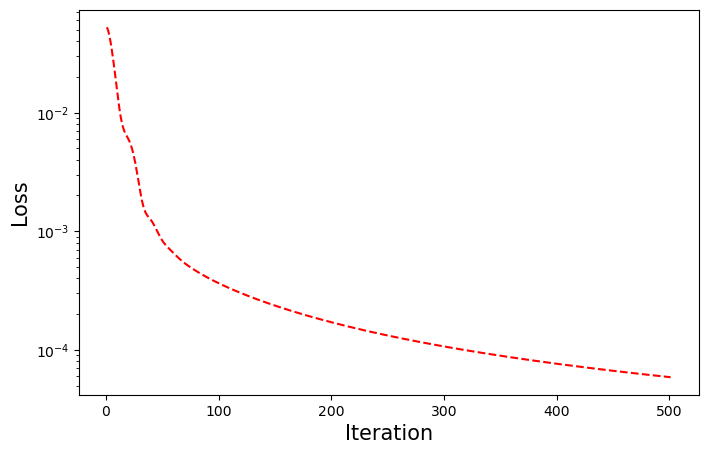

In [30]:
plt.figure(figsize=[8,5])

plt.plot(range(1,len(losses)+1),losses,'r--')
#plt.title('Traveltime tomography', fontsize=15)
plt.yscale("log")
plt.xlabel('Iteration', fontsize=15)
plt.ylabel('Loss', fontsize=15)

plt.show()

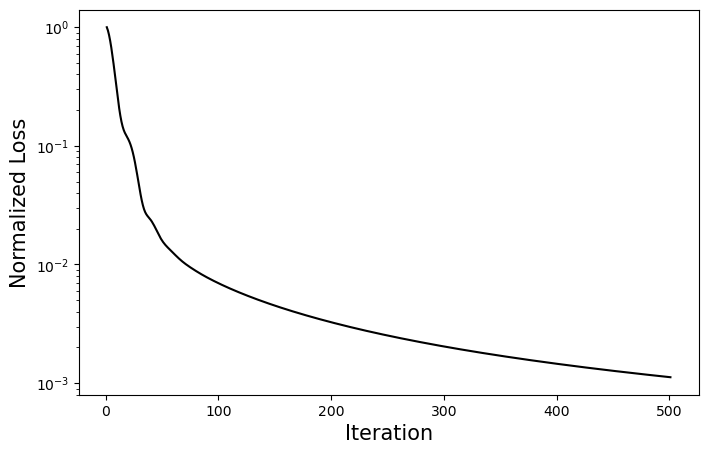

In [31]:
plt.figure(figsize=[8,5])

plt.plot(range(1,len(norm_losses)+1),norm_losses,'k-')
#plt.title('Traveltime tomography', fontsize=15)
plt.yscale("log")
plt.xlabel('Iteration', fontsize=15)
plt.ylabel('Normalized Loss', fontsize=15)

plt.show()

In [32]:
vel()

Parameter containing:
tensor([[1.5000, 1.5000, 1.5000,  ..., 4.3776, 4.4388, 4.5000],
        [1.5000, 1.5000, 1.5000,  ..., 4.3776, 4.4388, 4.5000],
        [1.5000, 1.5000, 1.5000,  ..., 4.3776, 4.4388, 4.5000],
        ...,
        [1.5000, 1.5000, 1.5000,  ..., 4.3776, 4.4388, 4.5000],
        [1.5000, 1.5000, 1.5000,  ..., 4.3776, 4.4388, 4.5000],
        [1.5000, 1.5000, 1.5000,  ..., 4.3776, 4.4388, 4.5000]],
       dtype=torch.float64, requires_grad=True)

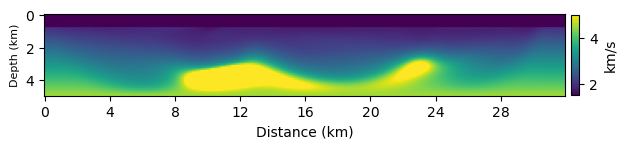

In [33]:
plt.figure(figsize=[8,3])
plt.imshow(vel().detach().numpy().T, vmin=1.5, vmax=5.0)
plt.xticks(np.arange(0, 320, 40), np.arange(0, 32, 4))
plt.yticks(np.arange(0, 50, 20), np.arange(0, 5, 2))
plt.xlabel("Distance (km)",fontsize=10)
plt.ylabel("Depth (km)",fontsize=8)
plt.colorbar(shrink=0.35, aspect=10, pad=0.01, label="km/s")

In [34]:
ssim = SSIM()

ax = np.arange(0, 320)

In [35]:
def evaluate(ttime_obs, vel,vtrue):
    since = time.time()
    
    test_mae = 0.0
    test_mse = 0.0
    test_ssim = 0.0
    test_loss = 0.0
    
    tomo.factorize(omega, vel())
    ttime = tomo.forward(vel(), torch.from_numpy(sxs), sy, ry) * rcv_mask
    
    tr_loss = torch.sum((ttime_obs - ttime).abs())/(nshot*100)
    #tr_loss = F.l1_loss(ttime, ttime_obs)
    
    vel = vel().reshape(1,1,320,50)
    if vel.type() != vtrue.type():
        vtrue = vtrue.double()
    vtrue = vtrue.reshape(1,1,320,50)

    mae_loss = F.l1_loss(vel, vtrue)
    mse_loss = F.mse_loss(vel, vtrue)
    ssim_loss = ssim(vel, vtrue)
    loss = mae_loss + mse_loss + (1 - ssim_loss)
    
    time_elapsed = time.time() - since
    print('Traveltime MAE: {:.10f} Loss: {:.4f} MAE: {:.4f} MSE {:.4f} SSIM {:.4f}'.format(
        tr_loss, loss, mae_loss, mse_loss, ssim_loss))
    print('Total time elapesd of test data {:.0f}ms'.format(
        time_elapsed))
    return tr_loss, loss, mae_loss, mse_loss, ssim_loss

In [36]:
vtrue = np.load("../../data/ml_vel/vel%05d.npy"%ivel)
vtrue.shape = (nx,ny)

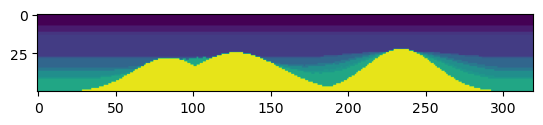

In [37]:
plt.imshow(vtrue.T, vmin=1.5, vmax=5.0)

In [38]:
vtrue = torch.from_numpy(vtrue)

In [39]:
vtrue.type()

'torch.FloatTensor'

In [40]:
vel().type()

'torch.DoubleTensor'

In [41]:
tr_loss, test_loss, test_mae, test_mse, test_ssim= evaluate(ttime_obs, vel, vtrue)

Traveltime MAE: 0.0050913594 Loss: 0.9578 MAE: 0.3178 MSE 0.2335 SSIM 0.5935
Total time elapesd of test data 1ms


In [42]:
tr_loss, test_loss, test_mae, test_mse, test_ssim

(tensor(0.0051, grad_fn=<DivBackward0>),
 tensor(0.9578, dtype=torch.float64, grad_fn=<AddBackward0>),
 tensor(0.3178, dtype=torch.float64, grad_fn=<MeanBackward0>),
 tensor(0.2335, dtype=torch.float64, grad_fn=<MseLossBackward0>),
 tensor(0.5935, dtype=torch.float64, grad_fn=<MeanBackward0>))

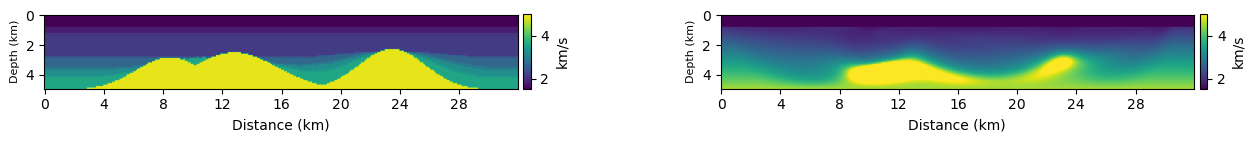

In [43]:
plt.figure(figsize=[16,3])
plt.subplot(1,2,1)
plt.imshow(vtrue.T, vmin=1.5, vmax=5.0)
plt.xticks(np.arange(0, 320, 40), np.arange(0, 32, 4))
plt.yticks(np.arange(0, 50, 20), np.arange(0, 5, 2))
plt.xlabel("Distance (km)",fontsize=10)
plt.ylabel("Depth (km)",fontsize=8)
plt.colorbar(shrink=0.325, aspect=10, pad=0.01, label="km/s")
plt.subplot(1,2,2)
plt.imshow(vel().detach().numpy().T, vmin=1.5, vmax=5.0)
plt.xticks(np.arange(0, 320, 40), np.arange(0, 32, 4))
plt.yticks(np.arange(0, 50, 20), np.arange(0, 5, 2))
plt.xlabel("Distance (km)",fontsize=10)
plt.ylabel("Depth (km)",fontsize=8)
plt.colorbar(shrink=0.325, aspect=10, pad=0.01, label="km/s")

In [44]:
#prediction = np.fromfile("./pred_test02160.bin",dtype=np.float32)
#prediction = np.fromfile("./pred_test02720.bin",dtype=np.float32)
prediction = np.fromfile("./pred_test04000.bin",dtype=np.float32)
prediction.shape = (nx,ny)

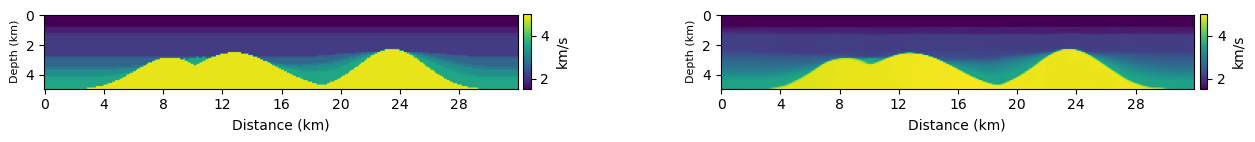

In [45]:
plt.figure(figsize=[16,3])
plt.subplot(1,2,1)
plt.imshow(vtrue.T, vmin=1.5, vmax=5.0)
plt.xticks(np.arange(0, 320, 40), np.arange(0, 32, 4))
plt.yticks(np.arange(0, 50, 20), np.arange(0, 5, 2))
plt.xlabel("Distance (km)",fontsize=10)
plt.ylabel("Depth (km)",fontsize=8)
plt.colorbar(shrink=0.325, aspect=10, pad=0.01, label="km/s")
plt.subplot(1,2,2)
plt.imshow(prediction.T, vmin=1.5, vmax=5.0)
plt.xticks(np.arange(0, 320, 40), np.arange(0, 32, 4))
plt.yticks(np.arange(0, 50, 20), np.arange(0, 5, 2))
plt.xlabel("Distance (km)",fontsize=10)
plt.ylabel("Depth (km)",fontsize=8)
plt.colorbar(shrink=0.325, aspect=10, pad=0.01, label="km/s")

In [46]:
def plot_traveltime(ttime_obs, vel_tomo, vel_dl):
    
    tomo.factorize(omega, vel_tomo())
    ttime_tomo = tomo.forward(vel_tomo(), torch.from_numpy(sxs), sy, ry) * rcv_mask
    
    tomo.factorize(omega, vel_dl())
    ttime_dl = tomo.forward(vel_dl(), torch.from_numpy(sxs), sy, ry) * rcv_mask
    
    plt.figure(figsize=[12,4])
    plt.xlabel('Distance (km)', fontsize=15)
    plt.ylabel('Time (s)', fontsize=15)
    plt.plot(ax[ttime_obs[0]>0], ttime_obs[0,ttime_obs[0]>0], "r-", label="Observed")
    plt.plot(ax[ttime_tomo[0].detach().numpy()>0], ttime_tomo[0,ttime_tomo[0]>0].detach().numpy(), "b--", label="Modeled_tomo")
    plt.plot(ax[ttime_dl[0].detach().numpy()>0], ttime_dl[0,ttime_dl[0]>0].detach().numpy(), "c-.", label="Modeled_dl")
    plt.legend(loc="upper right")
    
    plt.plot(ax[ttime_obs[49]>0], ttime_obs[49,ttime_obs[49]>0], "r-", label="Observed")
    plt.plot(ax[ttime_tomo[49].detach().numpy()>0], ttime_tomo[49,ttime_tomo[49]>0].detach().numpy(), "b--", label="Modeled_tomo")
    plt.plot(ax[ttime_dl[49].detach().numpy()>0], ttime_dl[49,ttime_dl[49]>0].detach().numpy(), "c-.", label="Modeled_dl")
    
    plt.plot(ax[ttime_obs[99]>0], ttime_obs[99,ttime_obs[99]>0], "r-", label="Observed")
    plt.plot(ax[ttime_tomo[99].detach().numpy()>0], ttime_tomo[99,ttime_tomo[99]>0].detach().numpy(), "b--", label="Modeled_tomo")
    plt.plot(ax[ttime_dl[99].detach().numpy()>0], ttime_dl[99,ttime_dl[99]>0].detach().numpy(), "c-.", label="Modeled_dl")
   
    plt.plot(ax[ttime_obs[149]>0], ttime_obs[149,ttime_obs[149]>0], "r-", label="Observed")
    plt.plot(ax[ttime_tomo[149].detach().numpy()>0], ttime_tomo[149,ttime_tomo[149]>0].detach().numpy(), "b--", label="Modeled_tomo")
    plt.plot(ax[ttime_dl[149].detach().numpy()>0], ttime_dl[149,ttime_dl[149]>0].detach().numpy(), "c-.", label="Modeled_dl")
    
    plt.plot(ax[ttime_obs[199]>0], ttime_obs[199,ttime_obs[199]>0], "r-", label="Observed")
    plt.plot(ax[ttime_tomo[199].detach().numpy()>0], ttime_tomo[199,ttime_tomo[199]>0].detach().numpy(), "b--", label="Modeled_tomo")
    plt.plot(ax[ttime_dl[199].detach().numpy()>0], ttime_dl[199,ttime_dl[199]>0].detach().numpy(), "c-.", label="Modeled_dl")
    plt.xticks(np.arange(0, 320, 50), np.arange(0, 32, 5))

In [47]:
vel_dl = param_selector('velocity',prediction,vmin,vmax)

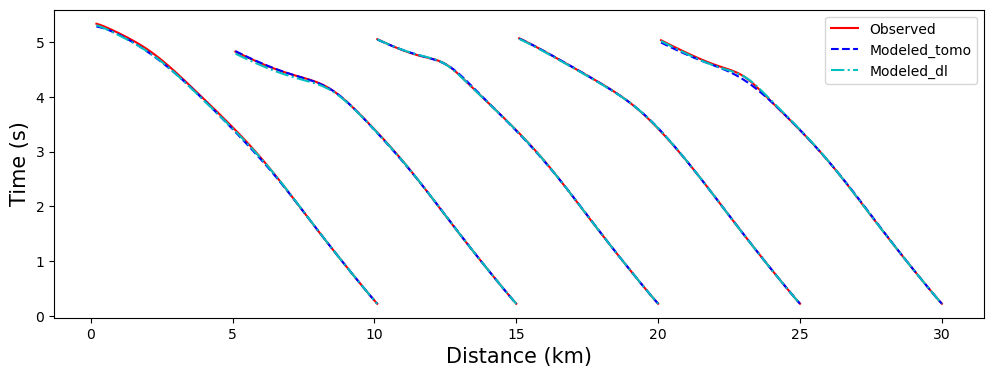

In [48]:
plot_traveltime(ttime_obs, vel, vel_dl)

In [49]:
tr_loss, test_loss, test_mae, test_mse, test_ssim= evaluate(ttime_obs, vel_dl, vtrue)

Traveltime MAE: 0.0086971419 Loss: 0.2000 MAE: 0.0589 MSE 0.0187 SSIM 0.8777
Total time elapesd of test data 1ms


In [50]:
tr_loss, test_loss, test_mae, test_mse, test_ssim

(tensor(0.0087, grad_fn=<DivBackward0>),
 tensor(0.2000, grad_fn=<AddBackward0>),
 tensor(0.0589, grad_fn=<MeanBackward0>),
 tensor(0.0187, grad_fn=<MseLossBackward0>),
 tensor(0.8777, grad_fn=<MeanBackward0>))